In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from pathlib import Path
import glob, os
from collections import defaultdict
from sklearn import preprocessing

cwd = Path("C:\\Users\\piyush\\Desktop\\mtp\\expt\\")
dict_for_uts = pd.read_csv(cwd/'dict_for_uts.csv').iloc[:,1:4]
dict_for_uts[:4]

all_files = Path(cwd/"FORCE").glob("*.xls")

rpm_dict, vel_dict = defaultdict(list), defaultdict(list)
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, delimiter="\t")
    df = df.loc[df['X-Pos'] > 5+df['X-Pos'][0]]
    m = df['Z-Load'][:200].mean()
    df = df.loc[df['Z-Load'] > m*(1-0.1)]
    df["Y_Val"]=1
    li.append(df)

for df in li:
    rpm = dict_for_uts.iloc[(dict_for_uts['rpm']-int(round(df.iloc[0:100]["Spindle RPM"].mean(), -2))).abs().argsort()[0]]["rpm"]
    vel = int(round(df.iloc[0:50]['X-Velocity'].mean(), -1))
    uts = dict_for_uts.loc[(dict_for_uts['rpm']==rpm) & (dict_for_uts['ws']==vel)]['UTS (MPa)'].iloc[0]
    df["UTS"] = uts
    rpm_dict[int(rpm)].append(df)
    vel_dict[vel].append(df)

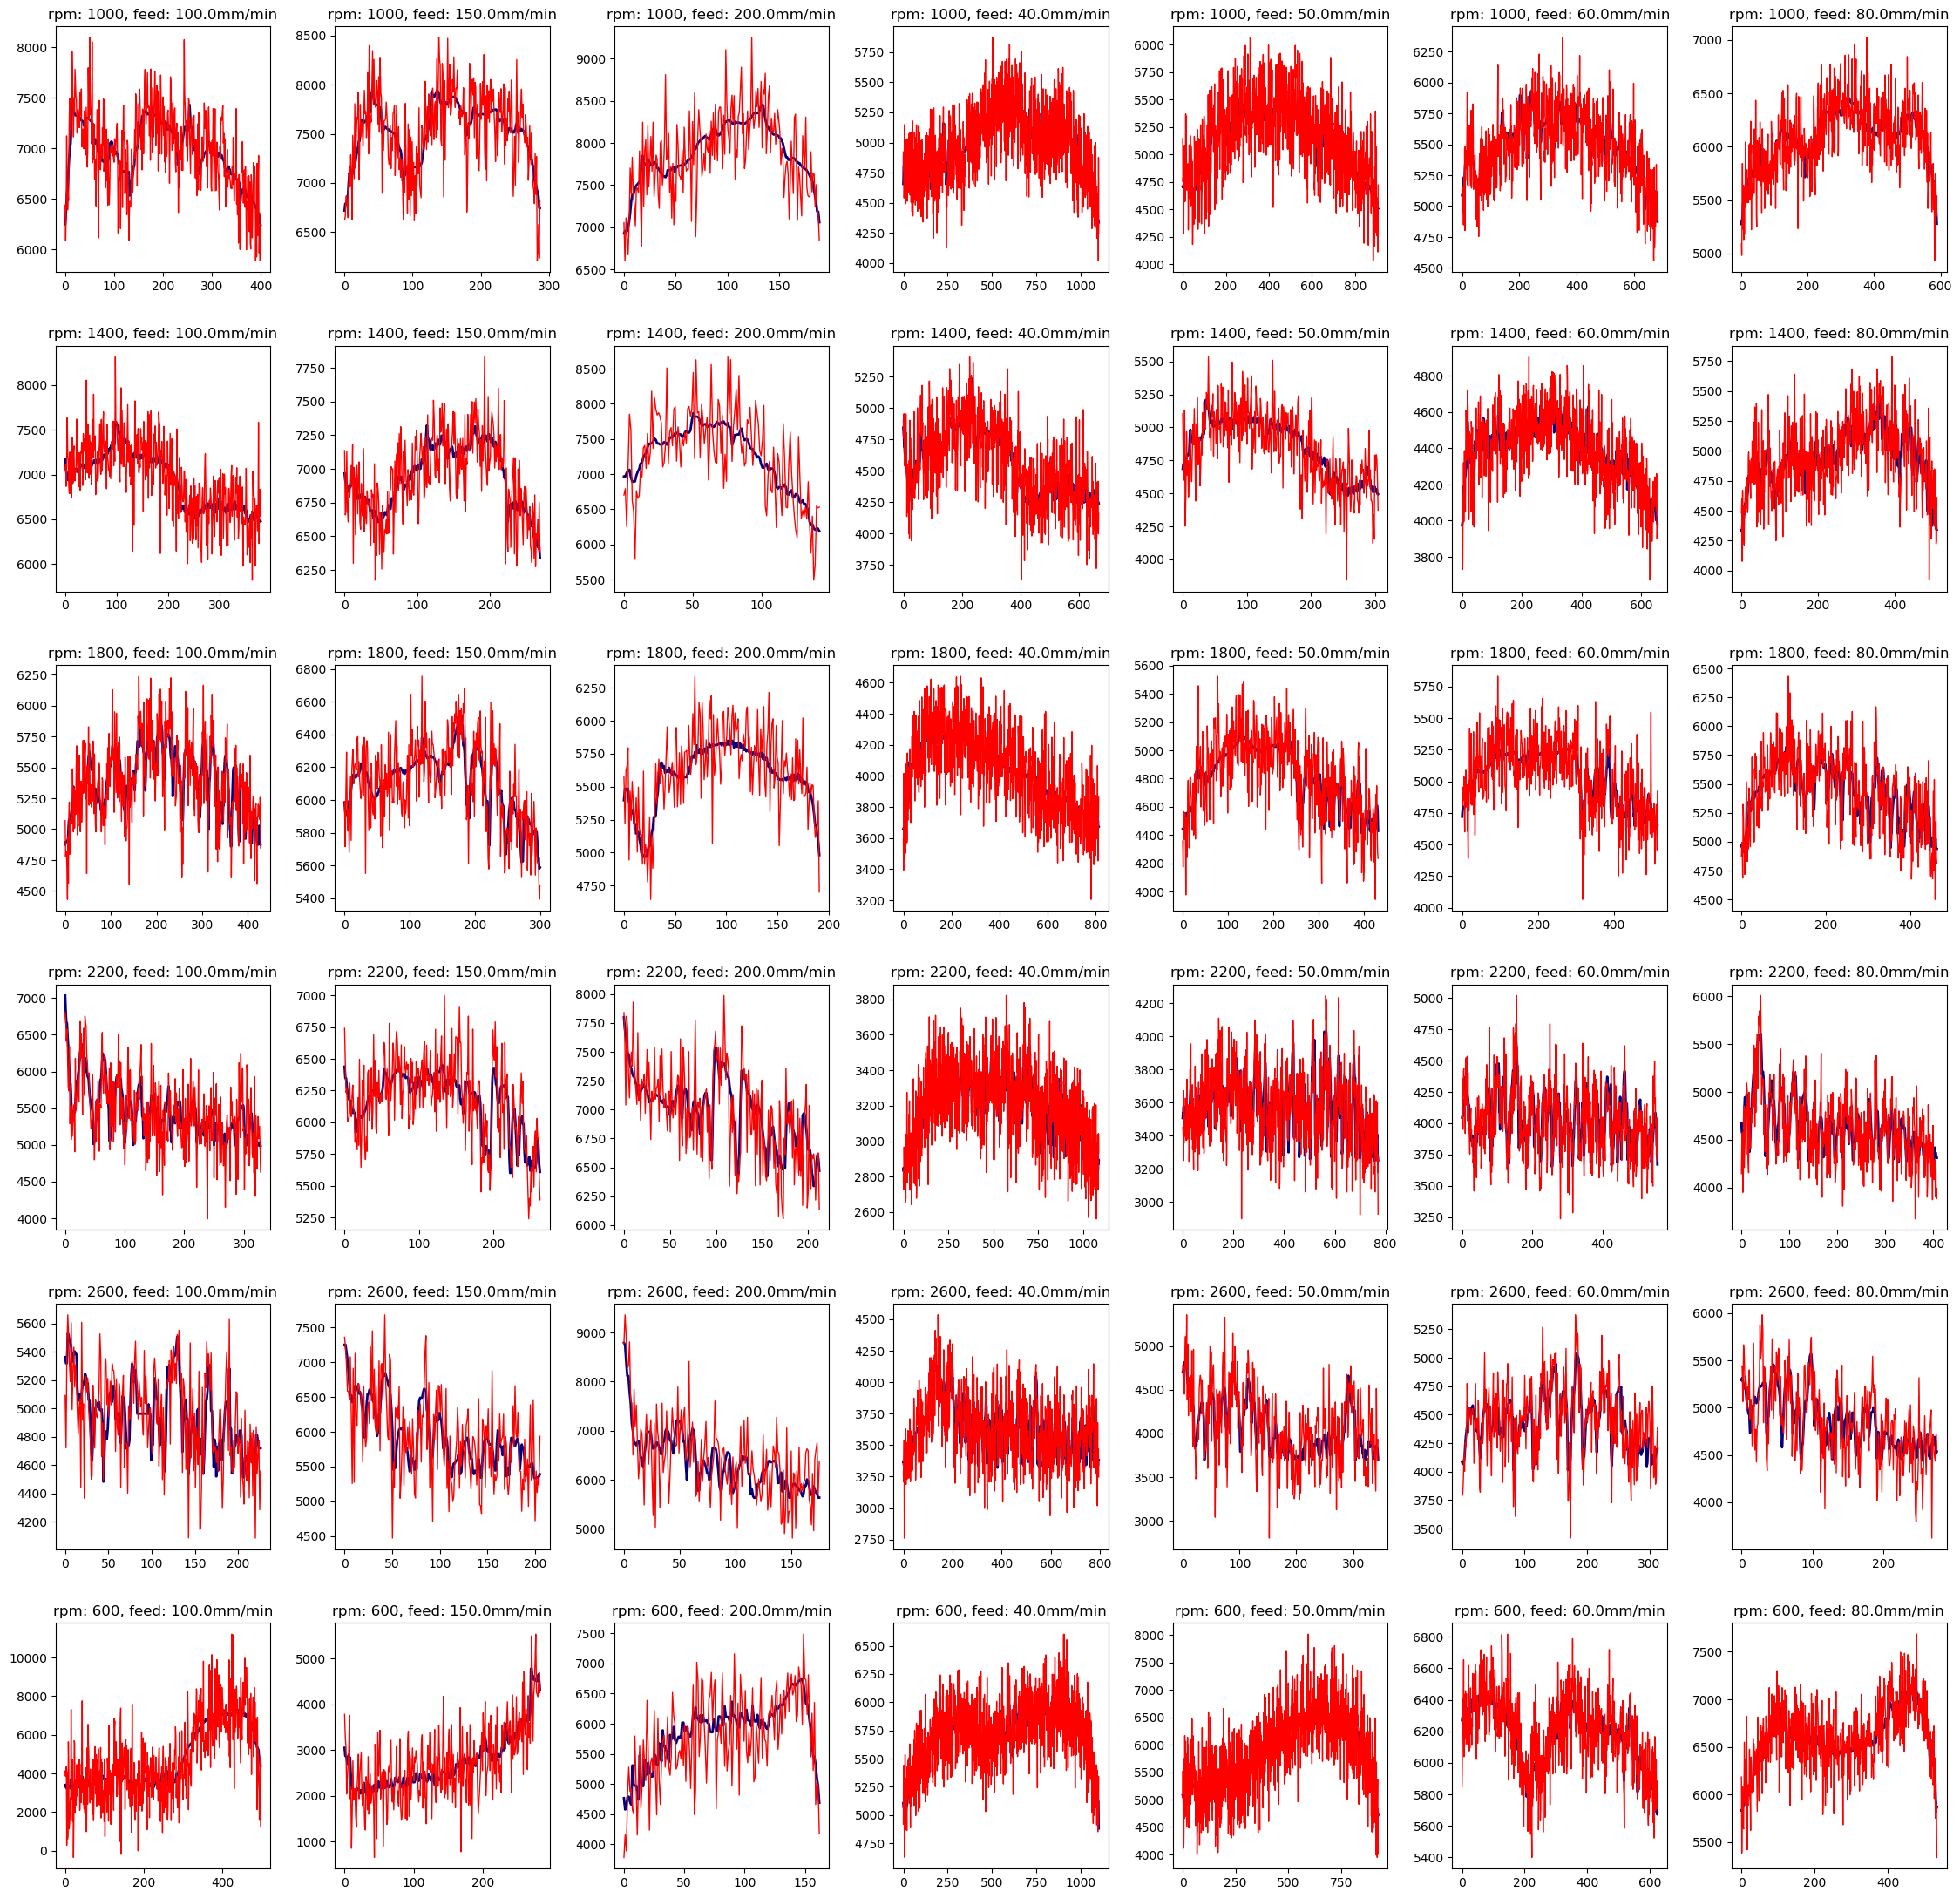

In [3]:
noisy_li = []
ini = 0
fig = plt.figure(figsize=(28, 28), dpi=100, facecolor='w', edgecolor='k')
plt.subplots_adjust(hspace = 0.3, wspace=0.3)
for key in rpm_dict:
    for num, df in enumerate(rpm_dict[key]):
#         load_values = df["Z-Load"]
        sigma = np.std(df["Z-Load"])
        
        load = df['Z-Load']
        noisy_load = load + np.random.normal(0,sigma,load.shape)
        
        noisy_li.append(pd.concat([df[["X-Velocity", "Spindle RPM"]],
                        (df['Z-Load'] + np.random.normal(0,sigma,df["Z-Load"].shape)),
                                   df['UTS']], axis=1))
        noisy_li[-1]["Y_Val"] = 0
        
        ax = fig.add_subplot(6,7,ini+num+1)
        
        vel = round(df['X-Velocity'].iloc[:100].mean(), -1)
        ax.set_title("rpm: {}, feed: {}mm/min".format(key, vel))
        
        line_X = np.linspace(0, df["Z-Load"].shape[0], df["Z-Load"].shape[0])
        
        ax.plot(line_X, load, color='navy', linewidth=2, label='Normal')
        ax.plot(line_X, noisy_load, color='red', linewidth=1, label='Noisy')
        
        
    ini += num+1
        

In [4]:
li[0]

,Time (ms),X-Pos,X-Load,X-Torque,X-Velocity,Spindle Torque,Spindle RPM,Z-Load,Z-Position,Weld Temp,Y_Val,UTS
668,66800.0,144.7429,-1.7943,2.700,101.166,14.151,996.9602,6250.8242,81.295,0.0,1,235.4119
669,66900.0,144.9426,-1.7943,3.600,104.313,14.240,991.3322,6304.6538,81.295,0.0,1,235.4119
670,67000.0,145.1427,-1.7943,3.475,100.422,14.151,995.1040,6393.4727,81.295,0.0,1,235.4119
671,67100.0,145.3427,-1.7943,3.250,103.798,14.685,992.9490,6496.3472,81.295,0.0,1,235.4119
672,67200.0,145.5428,-1.7943,3.375,99.220,14.774,996.0704,6580.6812,81.295,0.0,1,235.4119
...,...,...,...,...,...,...,...,...,...,...,...,...
1063,106300.0,210.7102,-1.7943,0.625,105.915,12.816,999.0550,6340.5405,81.300,0.0,1,235.4119
1064,106400.0,210.7102,-1.7943,0.625,105.915,12.816,999.0550,6340.5405,81.300,0.0,1,235.4119
1065,106500.0,210.9101,-1.7943,1.250,99.964,12.193,1000.4016,6301.9624,81.300,0.0,1,235.4119
1066,106600.0,211.1100,-1.7943,1.450,98.820,12.371,999.5542,6264.5806,81.300,0.0,1,235.4119


In [5]:
noisy_li[0]

,X-Velocity,Spindle RPM,Z-Load,UTS,Y_Val
668,101.166,996.9602,6116.768896,235.4119,0
669,104.313,991.3322,6469.363841,235.4119,0
670,100.422,995.1040,6427.963773,235.4119,0
671,103.798,992.9490,6413.835942,235.4119,0
672,99.220,996.0704,6789.558464,235.4119,0
...,...,...,...,...,...
1063,105.915,999.0550,6616.515053,235.4119,0
1064,105.915,999.0550,6493.952715,235.4119,0
1065,99.964,1000.4016,6217.200918,235.4119,0
1066,98.820,999.5542,6211.054781,235.4119,0


In [17]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Conv1D, MaxPooling1D 
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow as tf

In [21]:
tf.__version__
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [14]:
stds = preprocessing.StandardScaler()
stds.fit(pd.concat(li)["Z-Load"].values.reshape(-1, 1))
li_scaled = [stds.transform(x["Z-Load"].values.reshape(-1, 1)) for x in li]
noisy_li_scaled = [stds.transform(x["Z-Load"].values.reshape(-1, 1)) for x in noisy_li]

In [15]:
def LSTM_signal(freq):
    model = Sequential()
    # model.add(Conv1D(filters=32, kernel_size=3, input_shape=(16, 1), padding='same', activation='relu'))
    # model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(200, input_shape=(freq,1), dropout=0.05))
    model.add(Dense(128, activation='relu'))   
    model.add(Dropout(0.01))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
#     model.summary()
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

In [23]:
# with tf.device_scope('/gpu:0'):
with tf.device('/GPU:0'):
    lis = []
    for freq in range(10, 40):
        matrix, y = np.array([np.zeros(freq)]), []
        for x in li_scaled:
            for i in range(0, len(x), freq):
                try: matrix = np.concatenate((matrix, np.array([np.ravel(x[i:i+freq])]))); y.append(0)
                except: continue

        for noisy_x in noisy_li_scaled:
            for i in range(0, len(noisy_x), freq):
                try: matrix = np.concatenate((matrix, np.array([np.ravel(noisy_x[i:i+freq])]))); y.append(1)
                except: continue

        y = np.array(y); matrix = matrix[1:]
        from numpy import newaxis
        matrix = matrix[:, :, newaxis]
        y.shape, matrix.shape

        X_train,X_test,Y_train,Y_test = train_test_split(matrix,y,test_size=0.15)
        model = LSTM_signal(freq)
        model.fit(X_train,Y_train,batch_size=64,epochs=100, validation_split=0.2, verbose=0)
        loss, accr = model.evaluate(X_test,Y_test,verbose=0)
        print((freq, loss, accr))
        lis.append((freq, loss, accr))

(10, 0.07500816691691513, 0.9784768)
(11, 0.07422400099854706, 0.9744991)
(12, 0.056586465584541744, 0.98802394)
(13, 0.06713809855764025, 0.9762931)
(14, 0.03493386676405058, 0.98372096)
(15, 0.013699319157749414, 0.995)
(16, 0.11004915310289054, 0.9705882)
(17, 0.01181917091235888, 0.9915014)
(18, 0.13127162029226142, 0.97590363)
(19, 0.015467257103938165, 0.9904762)
(20, 0.09443402262404561, 0.98333335)
(21, 0.0058087093428822985, 1.0)
(22, 0.05580736744655844, 0.9852941)
(23, 0.020439620645573506, 0.99230766)
(24, 0.023952733841724694, 0.98790324)
(25, 0.058121304569384045, 0.9874477)
(26, 0.08536578030793167, 0.9781659)
(27, 0.05228729659098793, 0.97727275)
(28, 0.017000427329694163, 0.9953052)
(29, 0.03533095061869883, 0.99512196)
(30, 0.25914491402921336, 0.893401)
(31, 0.6845228441098598, 0.5497382)
(32, 0.019707192464367203, 0.9945652)
(33, 0.13097820698424092, 0.96089387)
(34, 0.20675299907552785, 0.87931037)
(35, 0.3065453810351236, 0.8452381)
(36, 0.02794503007995456, 0.993

In [28]:
pd.DataFrame(lis, columns=['Frequency', 'Loss', 'Accuracy']).to_csv('results.csv', index=False)